# Twitter user gender classification


In [1]:
% pylab inline
import pandas as pd
#import numpy as np
import matplotlib as plt
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
import nltk
from nltk.corpus import stopwords 
import string
import heapq
import operator
import re
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from nltk.stem.wordnet import WordNetLemmatizer
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.utils.extmath import density
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten
from keras.layers.wrappers import TimeDistributed
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.layers.recurrent import SimpleRNN
from keras.layers import Dense, Dropout, Activation

import tweepy
from tweepy import OAuthHandler
from tweepy import Stream
from tweepy.streaming import StreamListener
import json
import os

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.
/usr/local/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


[nltk_data] Downloading package punkt to /home/oleg/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/oleg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/oleg/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Question 1
In this question we've preprocessed the data in our csv file and analyzed the given data.
We've printed out plots which indicates what are the most commonly used terms and hashtags used by the two opposite genders.

In [105]:
# Reading the data from the file
data_df=pd.read_csv('gender-classifier-DFE-791531.csv',header=0,encoding = 'latin1') #iso-8859-1

In [20]:
# This is the metadata of our training experiment.
# We can see what are our columns
print(data_df.axes)

[RangeIndex(start=0, stop=20050, step=1), Index(['_unit_id', '_golden', '_unit_state', '_trusted_judgments',
       '_last_judgment_at', 'gender', 'gender:confidence', 'profile_yn',
       'profile_yn:confidence', 'created', 'description', 'fav_number',
       'gender_gold', 'link_color', 'name', 'profile_yn_gold', 'profileimage',
       'retweet_count', 'sidebar_color', 'text', 'tweet_coord', 'tweet_count',
       'tweet_created', 'tweet_id', 'tweet_location', 'user_timezone'],
      dtype='object')]


In [102]:
def func(term):
    if term.startswith(('#','@')):
        return term
    else :
        return term.lower()

def clean(words_string):
    '''
    Returns a string after removing stop words and punctuations, lowering all characters and normalizing the words.
    '''
    terms=re.findall(r'('+'|'.join([letters_and_tags_str,emoticons_str])+')',words_string)
    
    stop = set(stopwords.words('english'))
    
    exclude=list(string.punctuation)
    exclude.append('rt')
    exclude.append('via')
    exclude=set(exclude)

    stop.union(exclude)
    
    lemma = WordNetLemmatizer()
    terms=[func(term) for term in terms]    
    stop_free=[i for i in terms if i not in stop]
    normalized = " ".join(lemma.lemmatize(term) for term in stop_free)
    return normalized

def uniteLists(list_of_lists_of_words):
    '''
    Doing flat reduce, returning only one list of strings 
    '''
    united=[]
    for list_of_words in list_of_lists_of_words:
        united+=list_of_words
    return united
def devideToTermsAndFreq(tfList):
    '''
    Returns all the terms and their frequencies in the given list.
    '''
    ans_terms=[]
    ans_freq=[]
    for key,val in tfList:
        ans_terms.append(key)
        ans_freq.append(val)
    return ans_terms,ans_freq
def createPlot(x_data,y_data,y_name,x_name,title,i,j,k,color,bartype):
    '''
    Prints a plot for the given inputs:
    x_data - an array for the x axes.
    y_data - an array for the y axes.
    y_name - the label for the y axes.
    x_name - the label for the x axes.
    title - title for the plot.
    i,j,k,color,bartype - some data for the decoration of the graph.
    '''
    axis_font = {'family': 'serif','color':  'black','weight': 'normal','size': 18,}
    title_font = {'family': 'serif','color':  'black','weight': 'normal','size': 22,}
    font_size=16
    df=pd.DataFrame(data={x_name:x_data,y_name:y_data})
    temp = df.pivot_table(values=y_name,index=x_data)
    temp.sort_values(by=(y_name), ascending=True,inplace=True)
    ax = fig.add_subplot(i,j,k) #121
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(font_size)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(font_size)
    ax.set_xlabel(x_name,fontdict=axis_font)
    ax.set_ylabel(y_name,fontdict=axis_font)
    ax.set_title(title,fontdict=title_font)
    temp.plot(kind=bartype,ax=ax,cmap=color)

def findColDiff(df,col_name1,col_name2):
    return df[[col_name1,col_name2]][data_df[col_name1] != data_df[col_name2]]

def printNewCols(start,end):
    for i in range(start,end) :
        print(data_df.iloc[i]['text'])
        print(data_df.iloc[i]['clean_text'])
        print(data_df.iloc[i]['clean_words_list'])
        print(data_df.iloc[i]['hashtags'])
        print(data_df.iloc[i]['user_tag'])
        print()
def printCell(df,rowNum,colName):     
    print(data_df.loc[rowNum][colName])
    print(data_df.loc[rowNum][colName])
    print(data_df.loc[rowNum][colName])

### regular expressions for text filtering

In [22]:
emoticons_str = r"""(?:[:=;][oO\-]?[D\)\]\(\]/\\OpP])"""
html_str=r'<[^>]+>'
user_tags_str=r'(?:@[\w_]+)'
hashtags_str='#[a-zA-Z0-9]+'
url_str= r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+'
number_str= r'(?:(?:\d+,?)+(?:\.?\d+)?)'
another_str=r"(?:[a-zA-Z0-9#@][a-zA-Z0-9#@'\-_]+[a-zA-Z0-9#@])" # words with - and '
letters_and_tags_str='[a-z\'A-Z0-9#@][a-z\'A-Z0-9#@.-_]*'

### cleaning the data

- **'text'**- sentence per user cleaned from http links and garbage letters.
- **'hashtag'**- list of #hashtags per user.
- **'user_tag'** - list of @user_tags per user.
- **'clean_text'**- same as 'text' just without #tags and @tags.
- **'clean_words_list'**- same as 'clean_text' just splitted to list of words per user.

In [106]:
def extractCleanedDataFromTweets(df):
    df = df[df['gender'].apply(lambda x : (x=='male' or x=='female') )]
    df['emo']= df['text'].apply(lambda x : re.findall(emoticons_str,x))

    df['text']=df['text'].apply(lambda x :  re.sub(url_str,"",x))
    df['text']=df['text'].apply(lambda x :  " ".join(re.findall(r'('+'|'.join([letters_and_tags_str,emoticons_str])+')',x)))
    df['text']=df['text'].apply(lambda x :  re.sub('\'','',x))
    df['text']=df['text'].apply(lambda x :  re.sub('-','',x))
    df['text']=df['text'].apply(lambda x :  re.sub('_','',x))
    df['text']=df['text'].apply(lambda x :  re.sub('[\s]+',' ',x))

    df['hashtags']=df['text'].apply(lambda x :  re.findall(hashtags_str,x))
    df['user_tag']=df['text'].apply(lambda x :  re.findall(user_tags_str,x))
    df['clean_text']=df['text'].apply(lambda x :  re.sub('[#@]\S+\s*',"",x))
    df['clean_text']=df['clean_text'].apply(clean)
    df['clean_words_list']=df['clean_text'].apply(lambda x:re.findall('[a-zA-Z0-9]+',x))
    df['terms']=df['text'].apply(lambda x : clean(x).split())
    return df

pd.options.mode.chained_assignment = None
data_df=extractCleanedDataFromTweets(data_df)

In [30]:
def getTfByGender(data_df, gender):
    gender_words=uniteLists(data_df['clean_words_list'][data_df['gender'].apply(lambda x: x==gender)])
    return Counter(gender_words).most_common()
def getHashtagsByGender(data_df, gender):
    hashtag_words=uniteLists(data_df['hashtags'][data_df['gender'].apply(lambda x: x==gender)])
    return Counter(hashtag_words).most_common()
def getEmojiesByGender(data_df, gender):
    hashtag_words=uniteLists(data_df['emo'][data_df['gender'].apply(lambda x: x==gender)])
    return Counter(hashtag_words).most_common()

### male/female_tf contains is list of term:amount of appearnces for all terms per gender. 

In [25]:
male_tf = getTfByGender(data_df, 'male')
female_tf = getTfByGender(data_df, 'female')

### plot of the number of most common terms for male and female

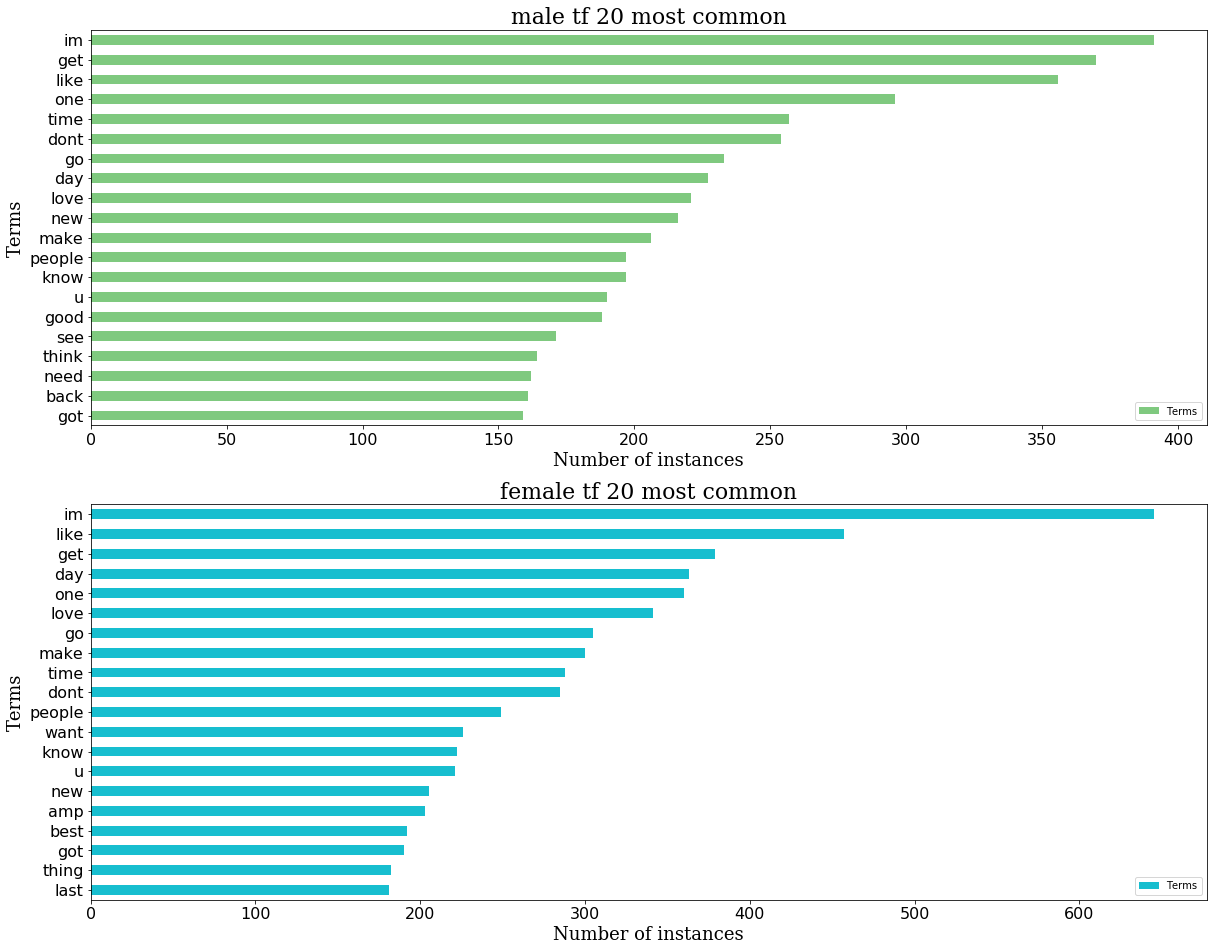

In [26]:
#pd.options.mode.chained_assignment
num=20
fig = plt.figure(figsize=(20,16))
terms,freq=devideToTermsAndFreq(male_tf)
createPlot(terms[:num],freq[:num],'Terms','Number of instances','male tf %s most common'%(num) ,2,1,1,'Accent','barh')
terms,freq=devideToTermsAndFreq(female_tf)
createPlot(terms[:num],freq[:num],'Terms','Number of instances','female tf %s most common'%(num),2,1,2,'Vega10_r','barh')

### male/female_hashtag_tf contains all the hashtag:amount of appearnces per gender. 


In [27]:
male_hashtag_tf = getHashtagsByGender(data_df, 'male')
female_hashtag_tf = getHashtagsByGender(data_df, 'female')

### plot for num most common #hashtags

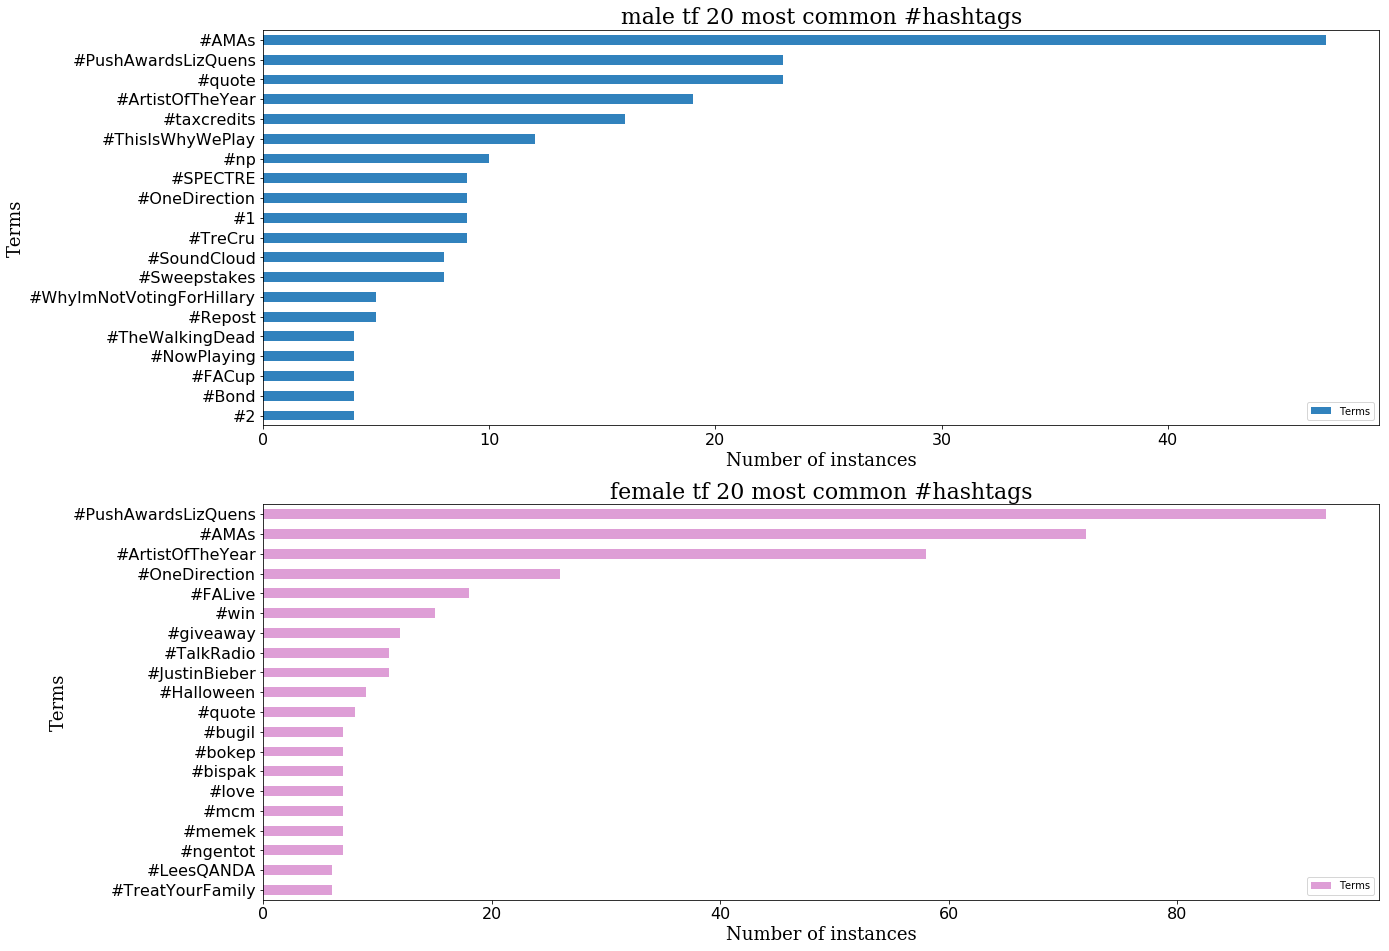

In [29]:
num=20
fig = plt.figure(figsize=(20,16))
terms,freq=devideToTermsAndFreq(male_hashtag_tf)
createPlot(terms[:num],freq[:num],'Terms','Number of instances','male tf %s most common #hashtags'%(num),2,1,1,'Vega20c','barh')
terms,freq=devideToTermsAndFreq(female_hashtag_tf)
createPlot(terms[:num],freq[:num],'Terms','Number of instances','female tf %s most common #hashtags'%(num),2,1,2,'Vega20b_r','barh')

### male/female_emo_tf contains emojie: amount of apperances per gender. 

In [31]:
male_emo_tf = getEmojiesByGender(data_df,'male')
female_emo_tf=getEmojiesByGender(data_df,'female')

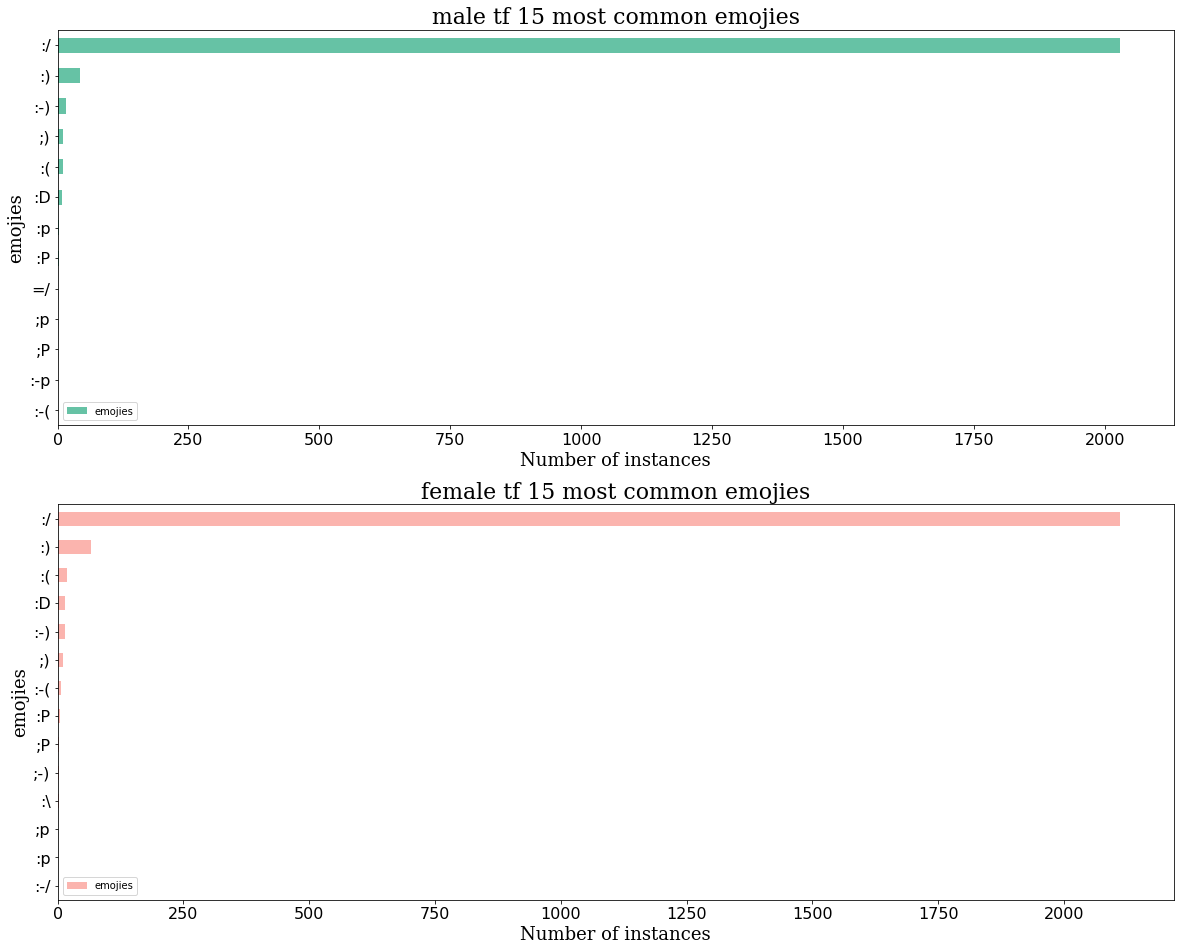

In [32]:
num=15
fig = plt.figure(figsize=(20,16))
terms,freq=devideToTermsAndFreq(male_emo_tf)
createPlot(terms[:num],freq[:num],'emojies','Number of instances','male tf %s most common emojies'%(num),2,1,1,'Set2','barh')
terms,freq=devideToTermsAndFreq(female_emo_tf)
createPlot(terms[:num],freq[:num],'emojies','Number of instances','female tf %s most common emojies'%(num),2,1,2,'Pastel1','barh')

# Question 2
# Train a machine learning model to predict the gender of the tweet author

### functions for question 2

In [109]:
#################################### change gender col in df from string to numeric and vice versa
def changeGenderToNum(word): 
    if word=='male':
        return 1 
    return 0
def changeNumToGender(num):
    if num==0:
        return 'female' 
    return 'male'
####################################

#################################### help us to run multiple classifiction algorithms easier.
def benchmark(clf,x_train,y_train): 
    print('_' * 80)
    print("Training: ")
    print(clf)
    scores = cross_val_score(clf, x_train, y_train, cv=5)
    t0 = time()
    clf.fit(x_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(Y_test, pred)
    print("CV accuracy:   %0.3f" % scores.mean())
    print("Y_test accuracy:   %0.3f" % score)

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time

In [139]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

data_df['num_gender']=data_df['gender'].apply(changeGenderToNum)

word_for_voc=[]
        
for i in data_df['terms']:
    for j in i:
        word_for_voc.append(j)

word_for_voc=set(word_for_voc)

#vectorizer = CountVectorizer(ngram_range=(1,2),lowercase=False,vocabulary=word_for_voc)
#vectorizer = CountVectorizer(ngram_range=(1,2),lowercase=False,token_pattern=letters_and_tags_str)
vectorizer = TfidfVectorizer(ngram_range=(1,2),lowercase=False,token_pattern=letters_and_tags_str)

test_size=10000
corpus_train=data_df['text'].tolist()[:test_size]

corpus_test=data_df['text'].tolist()[test_size:test_size*2]

vectorizer.fit(word_for_voc)

X_train = vectorizer.transform(corpus_train)
Y_train = data_df['num_gender'][:test_size].tolist()

X_test = vectorizer.transform(corpus_test)
Y_test = data_df['num_gender'][test_size:test_size*2].tolist()

In [132]:
len(vectorizer.vocabulary_)
#len(word_for_voc)
#vectorizer.vocabulary_.keys()

29152

In [137]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

results = []
SVM=SGDClassifier()
NB=MultinomialNB()
KN=KNeighborsClassifier(15)
for clf, name in (
        (SVM,"SVM"),
        (KN, "kneighbors"),
        (NB,"Naive Bayes")
    ):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf,X_train,Y_train))

SVM
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
train time: 0.007s
test time:  0.000s
CV accuracy:   0.569
Y_test accuracy:   0.585

kneighbors
________________________________________________________________________________
Training: 
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform')


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/site-packages/s

train time: 0.002s
test time:  0.533s
CV accuracy:   0.504
Y_test accuracy:   0.501

Naive Bayes
________________________________________________________________________________
Training: 
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
train time: 0.005s
test time:  0.001s
CV accuracy:   0.574
Y_test accuracy:   0.608



In [ ]:
X_train=X_train.toarray()
Y_train=np.asarray(Y_train)
X_test=X_test.toarray()
Y_test=np.asarray(Y_test)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
import numpy
# fix random seed for reproducibility
numpy.random.seed(7)
# split into input (X) and output (Y) variables
# create model

model = Sequential()
model.add(Dense(X_train.shape[0], input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(X_train.shape[0], activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# Compile model
model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy'])
# Fit the model
model.fit(X_train, Y_train, epochs=3, batch_size=50)
# evaluate the model
scores = model.evaluate(X_test, Y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

## Question 3

## Get most tweeted country
We've tried to find which country has the biggest number of tweets in our datasets,
as we can see, combining all the tweets from all the states of USA reveals that it is the most tweeted country.

In [ ]:
locations = data_df['tweet_location'][data_df['tweet_location'].apply(lambda x: type(x) == str)]
locations=locations.apply(clean)
locations_tf = Counter(locations).most_common()
locations_tf

In [ ]:
# Parameters and functionality initialization for our interaction with twitter api

consumer_key = 'aZgjP0NZeM4iiBaQXJcyOKLJB'
consumer_secret = 'VRLyop5JLP8Kh91CMnE0rpOKUhKEtrrVTCOozHVOd8QEFx69XX'
access_token = '326266960-9RZItG8Q4FUER0BOX4eO8mrvsvrrDWzaWiJqoens'
access_secret = 'v6UHn9puTUv5OgcDwGqf3UxfCZv6XSJZ1gB8UkXOFrnQo'

auth = OAuthHandler(consumer_key,consumer_secret)
auth.set_access_token(access_token,access_secret)

api = tweepy.API(auth)

In [ ]:
JSON_MALE_FILE_NAME='male_tweets.json'
JSON_FEMALE_FILE_NAME='female_tweets.json'
MAX_NUMBER_OF_TWEETS = 219
MALE_FILTER_HASHTAG = '#nba'
FEMALE_FILTER_HASHTAG = '#femalefilmmakerfriday'

class MyListener(StreamListener):
    def __init__(self, jsonFileName):
        self.jsonFileName = jsonFileName
        self.f = open(jsonFileName, 'w')
        self.f.write('[')
        self.tweets_gathered = 0
    
    def on_data(self, data):
    #def on_status(self, status):
        #global tweets_gathered
        if MAX_NUMBER_OF_TWEETS > self.tweets_gathered:
            self.tweets_gathered += 1
            try:
                print(self.tweets_gathered)
                self.f.write(data.rstrip() + ',')
                return True
            except BaseException as e:
                print("Error on_data: %s" % str(e))
            return True
        else:
            self.f.seek
            return False
    def on_error(self, status):
        print("Error" + status)
        return True
    def __del__(self):
        self.f.close()
        #just a fix to the json file
        with open(self.jsonFileName, 'rb+') as self.f:
            self.f.seek(-1, os.SEEK_END)
            self.f.write(b']')    
        print('died')
    def on_exception(self, exception):
        print(exception)

def generateTweets(isMalesGender):
    if isMalesGender:
        jsonFileName = JSON_MALE_FILE_NAME
        filterHashtags = MALE_FILTER_HASHTAG
    else:
        jsonFileName = JSON_FEMALE_FILE_NAME
        filterHashtags = FEMALE_FILTER_HASHTAG
    myList = MyListener(jsonFileName)
    twitter_stream = Stream(auth, myList)
    # I think Asi said she gives up on the location part because students told her it is somewhat problematic with the other fiter.
    # those coordinates are boxed that represents most of america - the country that we've found to have the most tweetings. 
    #twitter_stream.filter(locations=[-124.89,32.7,-93.07,48.99,
    #                                 -110.64,31.98,-84.43,47.01,
    #                                -99.04,26.29,-72.83,41.58,
    #                                -79.0,32.1,-70.6,43.69,
    #                                -75.3,41.06,-66.91,45.06])
    twitter_stream.filter(track=[filterHashtags])
     
# From here we generate the two json files, one for males a
#generateTweets(True)
#generateTweets(False)

In [ ]:
new_twitts_male_df = pd.read_json(path_or_buf=JSON_MALE_FILE_NAME)
new_twitts_female_df = pd.read_json(path_or_buf=JSON_FEMALE_FILE_NAME)
new_twitts_male_df['gender'] = 'male'
new_twitts_female_df['gender'] = 'female'

new_twitts_df = new_twitts_male_df.append(new_twitts_female_df, ignore_index = True)

In [ ]:
new_twitts_df

In [ ]:
# fixes all the places part of the tweet was missing
for i in range(0, new_twitts_df.shape[0]):
    if pd.notnull(new_twitts_df.loc[i,'extended_tweet']):
        new_twitts_df['text'][i] = new_twitts_df['extended_tweet'][i]['full_text']

In [ ]:
def removePairFromList(lst, el):
    for pair in lst:
        if pair[0] == el:
            lst.remove(pair)

new_twitts_df = extractCleanedDataFromTweets(new_twitts_df)
new_twitts_male_tf = getTfByGender(new_twitts_df, 'male')
new_twitts_female_tf = getTfByGender(new_twitts_df, 'female')
removePairFromList(new_twitts_male_tf, 'rt')
removePairFromList(new_twitts_female_tf, 'rt')

num=15
fig = plt.figure(figsize=(20,16))
terms,freq=devideToTermsAndFreq(new_twitts_male_tf)
createPlot(terms[:num],freq[:num],'Terms','Number of instances','male tf %s most common'%(num) ,2,1,1,'Accent','barh')
terms,freq=devideToTermsAndFreq(new_twitts_female_tf)
createPlot(terms[:num],freq[:num],'Terms','Number of instances','female tf %s most common'%(num),2,1,2,'Vega10_r','barh')

### plot for num most common #hashtags

In [ ]:
male_hashtag_tf = getHashtagsByGender(new_twitts_df, 'male')
female_hashtag_tf = getHashtagsByGender(new_twitts_df, 'female')
removePairFromList(male_hashtag_tf, '#NBA')
removePairFromList(male_hashtag_tf, '#nba')
removePairFromList(female_hashtag_tf, '#FemaleFilmmakerFriday')
removePairFromList(female_hashtag_tf, '#femalefilmmakerfriday')

num=15
fig = plt.figure(figsize=(18,16))
terms,freq=devideToTermsAndFreq(male_hashtag_tf)
createPlot(terms[:num],freq[:num],'Terms','Number of instances','male tf %s most common #hashtags'%(num),2,1,1,'Vega20c','barh')
terms,freq=devideToTermsAndFreq(female_hashtag_tf)
createPlot(terms[:num],freq[:num],'Terms','Number of instances','female tf %s most common #hashtags'%(num),2,1,2,'Vega20b_r','barh')